 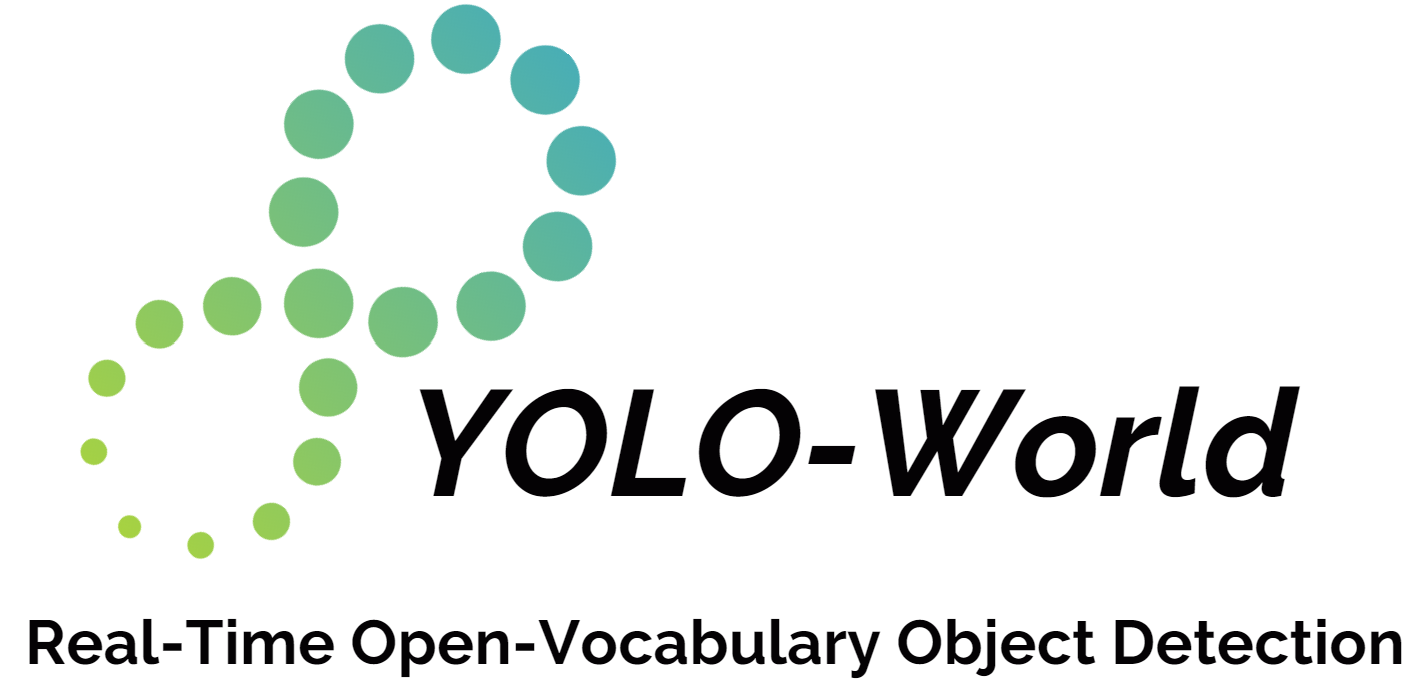


 This YOLO-World notebook is a Inferencing notebook presenting Real-Time Open-Vocabulary Object Detection.

We hope that the resources in this notebook will help you for inferencing.

## Setup

Clone GitHub [repository](https://github.com/AILab-CVC/YOLO-World) and install dependencies

In [2]:
!git clone --recursive https://github.com/AILab-CVC/YOLO-World
%cd YOLO-World/

Cloning into 'YOLO-World'...
remote: Enumerating objects: 1213, done.
remote: Counting objects: 100% (430/430), done.
remote: Compressing objects: 100% (193/193), done.
remote: Total 1213 (delta 314), reused 243 (delta 237), pack-reused 783 (from 2)
Receiving objects: 100% (1213/1213), 3.97 MiB | 8.70 MiB/s, done.
Resolving deltas: 100% (681/681), done.
Submodule 'third_party/mmyolo' (https://github.com/onuralpszr/mmyolo.git) registered for path 'third_party/mmyolo'
Cloning into '/content/YOLO-World/third_party/mmyolo'...
remote: Enumerating objects: 4944, done.        
remote: Counting objects: 100% (1421/1421), done.        
remote: Compressing objects: 100% (290/290), done.        
remote: Total 4944 (delta 1217), reused 1131 (delta 1131), pack-reused 3523 (from 3)        
Receiving objects: 100% (4944/4944), 3.61 MiB | 8.68 MiB/s, done.
Resolving deltas: 100% (3191/3191), done.
Submodule path 'third_party/mmyolo': checked out '4d97b3a06609dba94b8ec584be2f2029cfdb7519'
/content/YOLO

In [ ]:
import os
# Install certain version of requests, tqdm, rich for openxlab (fix for yolo_world)
# Install mmcv before avoding compiling of mmcv and shortining waiting time installs "whl" file
# Downgrade pytorch version for fast installing mmcv (your on prem should finish faster with latest pytorch)


if 'COLAB_GPU' in os.environ:
  !pip install torch==2.1.2 torchvision==0.16.2 torchaudio==2.1.2 --index-url https://download.pytorch.org/whl/cu121 -q
  !pip install requests==2.28.2 tqdm==4.65.0 rich==13.4.2 -q
  %pip install -U openmim -q
  !mim install "mmengine>=0.7.0" -q
  !mim install "mmcv" -q
else:
  !pip install torch wheel requests==2.28.2 tqdm==4.65.0 rich==13.4.2 -q

!pip install -e . -vv -q
!pip install mmcv==2.0.0rc4

In [3]:
if 'COLAB_GPU' in os.environ:
    # Restart colab session (required for yolo_world to work in google colab)
    quit()

## Pretrained Models

Download Pretrained weights from Huggingface and set configuration

In [1]:
import os

%cd YOLO-World/
if not os.path.exists("pretrained_weights"):
    os.makedirs("pretrained_weights")

# Download pretrained weights of YOLO-Worldv2-L	O365+GoldG img_size=1280 model
!wget -P pretrained_weights/ https://huggingface.co/wondervictor/YOLO-World/resolve/main/yolo_world_v2_l_obj365v1_goldg_pretrain_1280ft-9babe3f6.pth
!wget https://media.roboflow.com/notebooks/examples/dog.jpeg

/content/YOLO-World
--2025-04-27 07:24:46--  https://huggingface.co/wondervictor/YOLO-World/resolve/main/yolo_world_v2_l_obj365v1_goldg_pretrain_1280ft-9babe3f6.pth
Resolving huggingface.co (huggingface.co)... 18.164.174.55, 18.164.174.17, 18.164.174.118, ...
Connecting to huggingface.co (huggingface.co)|18.164.174.55|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.hf.co/repos/60/37/6037308e29abfdfd0058944e23eef6e0985d74bbb91fb2823de37a9ddfc4cc89/9babe3f6e2b73cd64f545b59de358fc7c47a85059cda9767f0a69f6bfae42d6d?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27yolo_world_v2_l_obj365v1_goldg_pretrain_1280ft-9babe3f6.pth%3B+filename%3D%22yolo_world_v2_l_obj365v1_goldg_pretrain_1280ft-9babe3f6.pth%22%3B&Expires=1745742286&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc0NTc0MjI4Nn19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zLzYwLzM3LzYwMzczMDhlMjlhYmZkZmQwMDU4OTQ0ZTIzZ

## Loading model configurations

In [11]:
import numpy as np
import torch
from mmengine.config import Config
from mmengine.dataset import Compose
from mmengine.runner import Runner
from mmengine.runner.amp import autocast
from mmyolo.registry import RUNNERS
from torchvision.ops import nms


if __name__ == "__main__":
    # load config
    cfg = Config.fromfile(
        "configs/pretrain/yolo_world_v2_l_vlpan_bn_2e-3_100e_4x8gpus_obj365v1_goldg_train_1280ft_lvis_minival.py"
    )
    cfg.work_dir = "."
    cfg.load_from = "pretrained_weights/yolo_world_v2_l_obj365v1_goldg_pretrain_1280ft-9babe3f6.pth"
    runner = Runner.from_cfg(cfg)
    runner.call_hook("before_run")
    runner.load_or_resume()
    pipeline = cfg.test_dataloader.dataset.pipeline
    runner.pipeline = Compose(pipeline)

    # run model evaluation
    runner.model.eval()

AssertionError: MMCV==2.2.0 is used but incompatible. Please install mmcv>=2.0.0rc4, <2.1.0.

In [3]:
def colorstr(*input):
    """
        Helper function for style logging
    """
    *args, string = input if len(input) > 1 else ("bold", input[0])
    colors = {"bold": "\033[1m"}

    return "".join(colors[x] for x in args) + f"{string}"

# Run Image Inference

In [6]:
import PIL.Image
import cv2
import supervision as sv

bounding_box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator(text_position=sv.Position.CENTER)
mask_annotator = sv.MaskAnnotator()

class_names = ("person, bicycle, car, motorcycle, airplane, bus, train, truck, boat, "
               "traffic light, fire hydrant, stop sign, parking meter, bench, bird, "
               "cat, dog, horse, sheep, cow, elephant, bear, zebra, giraffe, "
               "backpack, umbrella, handbag, tie, suitcase, frisbee, skis, snowboard, "
               "sports ball, kite, baseball bat, baseball glove, skateboard, "
               "surfboard, tennis racket, bottle, wine glass, cup, fork, knife, "
               "spoon, bowl, banana, apple, sandwich, orange, broccoli, carrot, "
               "hot dog, pizza, donut, cake, chair, couch, potted plant, bed, "
               "dining table, toilet, tv, laptop, mouse, remote, keyboard, "
               "cell phone, microwave, oven, toaster, sink, refrigerator, book, "
               "clock, vase, scissors, teddy bear, hair drier, toothbrush")

class_names2 = ("dog, eye, tongue, ear, leash")


def run_image(
        runner,
        input_image,
        max_num_boxes=100,
        score_thr=0.05,
        nms_thr=0.5,
        output_image="output.png",
):
    output_image = "runs/detect/"+output_image
    texts = [[t.strip()] for t in class_names.split(",")] + [[" "]]
    data_info = runner.pipeline(dict(img_id=0, img_path=input_image,
                                     texts=texts))

    data_batch = dict(
        inputs=data_info["inputs"].unsqueeze(0),
        data_samples=[data_info["data_samples"]],
    )

    with autocast(enabled=False), torch.no_grad():
        output = runner.model.test_step(data_batch)[0]
        runner.model.class_names = texts
        pred_instances = output.pred_instances

    # nms
    keep_idxs = nms(pred_instances.bboxes, pred_instances.scores, iou_threshold=nms_thr)
    pred_instances = pred_instances[keep_idxs]
    pred_instances = pred_instances[pred_instances.scores.float() > score_thr]

    if len(pred_instances.scores) > max_num_boxes:
        indices = pred_instances.scores.float().topk(max_num_boxes)[1]
        pred_instances = pred_instances[indices]
    output.pred_instances = pred_instances

    # predictions
    pred_instances = pred_instances.cpu().numpy()

    if 'masks' in pred_instances:
        masks = pred_instances['masks']
    else:
        masks = None

    detections = sv.Detections(
        xyxy=pred_instances['bboxes'],
        class_id=pred_instances['labels'],
        confidence=pred_instances['scores']
    )

    # label ids with confidence scores
    labels = [
        f"{class_id} {confidence:0.2f}"
        for class_id, confidence
        in zip(detections.class_id, detections.confidence)
    ]

    # draw bounding box with label
    image = PIL.Image.open(input_image)
    svimage = np.array(image)
    svimage = bounding_box_annotator.annotate(svimage, detections)
    svimage = label_annotator.annotate(svimage, detections, labels)
    if masks is not None:
        svimage = mask_annotator.annotate(image, detections)

    # save output image
    cv2.imwrite(output_image, svimage[:, :, ::-1])
    print(f"Results saved to {colorstr('bold', output_image)}")

    return svimage[:, :, ::-1]


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


In [10]:
img = run_image(runner,"dog.jpeg")
sv.plot_image(img)

NameError: name 'runner' is not defined